# Introduction and Business Understanding

More and more electric vehicles can be seen on the streets as they are slowly replacing traditional vehicles with combustion engines. Electric vehicles can do without a fuel tank; instead they have a powerful battery which is used both for moving the vehicle as well as for powering other consumers, such as heating, airconditioning, multimedia, and infotainment. 

Most drivers of electric vehicles are well aware of the "State of Charge" that shows how much power is left in the battery throughout a trip. The fear of a breakdown due to an empty battery has even received its own terminology: "Range Anxiety". 

This Data Science project focusses on the "State of Charge" (SoC) of electric vehicles, explores dependencies to measures taken during a vehicle's trip, and makes predictions of the required battery power for a vehicle's trip. 

For the analysis, a dataset is used which includes 70 trips of a BMW i3 in 2019 in and around Munich, Germany. Throughout the trips a variety of measures have been recorded, such as velocity, acceleration, ambient temperature, elevation, heating, air conditioning, motor torque, and more.

## Structure of this Notebook

- Introduction and Business Understanding
- Importing Required Libraries
- Step 1 | Loading Data
- Step 2 | Data Exploration, Data Cleansing, Data Visualization
- Step 3 | Data Preparation

# Importing Required Libraries

In [1]:
# Import libraries
import pandas as pd

from os import listdir
from os.path import isfile, join

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error

C:\ProgramData\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Step 1 | Loading Data 

In [2]:
# Retrieve csv filenames from battery_and_heating_data directory
tripdata = []
for f in listdir('battery_and_heating_data'):
    if f[-3:] == 'csv':
        tripdata.append(f)

In [3]:
# Read in all tripdata including the trip's id
trip_df = pd.DataFrame()
for f in tripdata:
    new_df = pd.read_csv(filepath_or_buffer=('battery_and_heating_data/'+f), sep=';', engine='python')
    new_df['trip_id'] = f[:-4]
    
    trip_df = pd.concat([trip_df, new_df], sort=False)

print(trip_df.shape)
trip_df.head()

(1094793, 51)


,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,Temperature Footweel Co-Driver [°C],Temperature Feetvent Co-Driver [°C],Temperature Feetvent Driver [°C],Temperature Head Co-Driver [°C],Temperature Head Driver [°C],Temperature Vent right [°C],Temperature Vent central right [°C],Temperature Vent central left [°C],Temperature Vent right [°C],Velocity [km/h]]]
0,0.0,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.20,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.1,0.0,574.0,0.0,0.0,0.00,0.0,391.4,-2.21,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.2,0.0,574.0,0.0,0.0,-0.01,0.0,391.4,-2.26,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.3,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.4,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Step 2 | Data Exploration, Data Cleansing, Data Visualization

To start our data exploration journey, we take the trip_df dataframe and run first queries against it.

In [4]:
number_of_trips = len(trip_df['trip_id'].unique())
print('The dataset contains ', number_of_trips, ' individual trips.')

The dataset contains  70  individual trips.


Upon checking the trips dataset for null values we find:
- (1) Column 'Unnamed: 23' has 99.9999 % missing values. We will remove this column.
- (2) There are two columns for velocity: 'Velocity [km/h]]]' and 'Velocity [km/h]'. We will combine them into one.
- (3) There are two columns for the right vent's temperature: 'Temperature Vent right [°C] ' and 'Temperature Vent right [°C]'. We will investigate further.

In [5]:
(trip_df.isnull().sum() / trip_df.shape[0]).sort_values(ascending=False)

Unnamed: 23                               0.999999
Velocity [km/h]]]                         0.984994
Coolant Volume Flow +500 [l/h]            0.453085
Temperature Defrost central right [°C]    0.431442
Ambient Temperature Sensor [°C]           0.431442
Temperature Coolant Heater Inlet [°C]     0.431442
Temperature Coolant Heater Outlet [°C]    0.431442
Temperature Heat Exchanger Outlet [°C]    0.431442
Temperature Defrost lateral left [°C]     0.431442
Temperature Defrost lateral right [°C]    0.431442
Temperature Defrost central left [°C]     0.431442
Temperature Defrost central [°C]          0.431442
Temperature Footweel Driver [°C]          0.431442
Temperature Footweel Co-Driver [°C]       0.431442
Temperature Feetvent Co-Driver [°C]       0.431442
Temperature Feetvent Driver [°C]          0.431442
Temperature Head Co-Driver [°C]           0.431442
Temperature Head Driver [°C]              0.431442
Temperature Vent right [°C]               0.431442
Temperature Vent central right 

In [6]:
# (1) Removing (almost) empty column 'Unnamed: 23'
trip_df.drop(columns=['Unnamed: 23'], inplace=True)

In [7]:
# (2) Combining two velocity columns into one
## Checking that the two velocity columns do not overlap
print('Number of empty values in column \'Velocity [km/h]\' when \'Velocity [km/h]]]\' is empty: ', 
      trip_df[trip_df['Velocity [km/h]]]'].isna()]['Velocity [km/h]'].isna().sum())
print('Number of empty values in column \'Velocity [km/h]]]\' when \'Velocity [km/h]\' is empty: ', 
      trip_df[trip_df['Velocity [km/h]'].isna()]['Velocity [km/h]]]'].isna().sum())

## Moving content of 'Velocity [km/h]]]' into 'Velocity [km/h]'
trip_df_v = trip_df[trip_df['Velocity [km/h]'].isna()].copy()
trip_df_v['Velocity [km/h]'] = trip_df_v['Velocity [km/h]]]']
trip_df = pd.concat([trip_df[trip_df['Velocity [km/h]]]'].isna()], trip_df_v])

## Removing no longer needed column 'Velocity [km/]]]'
trip_df.drop(columns=['Velocity [km/h]]]'], inplace=True)

Number of empty values in column 'Velocity [km/h]' when 'Velocity [km/h]]]' is empty:  0
Number of empty values in column 'Velocity [km/h]]]' when 'Velocity [km/h]' is empty:  0


In [8]:
# (3) Investigating temperature data from right vent
temp_vent_df = trip_df[['trip_id', 'Temperature Vent right [°C]', 'Temperature Vent right [°C] ']].copy()
temp_vent_df['Difference'] = temp_vent_df['Temperature Vent right [°C]'] - temp_vent_df['Temperature Vent right [°C] ']
print(temp_vent_df['Difference'].describe())

trip_df.rename(columns={'Temperature Vent right [°C]': 'Temperature Vent One [°C]', 
                        'Temperature Vent right [°C] ': 'Temperature Vent Two [°C]'},
              inplace=True)

count    622453.000000
mean         -2.079627
std           1.493197
min          -9.860000
25%          -2.310350
50%          -1.920000
75%          -1.400000
max           3.720000
Name: Difference, dtype: float64


We discover that the values of the two 'Temperature Vent right' columns differ from one another. It can thus be assumed that an error occured during data collection when labeling the data columns. Possibly, one of the columns should have been labeled 'Temperature Vent left [°C]'. To avoid missunderstandings during the upcoming data processing, we decide to remove the vents' locations from the column names and label the columns 'Temperature Vent One [°C]' and 'Temperature Vent Two [°C]' instead.

We are now taking a look at the trips in more details. For that we are visualizing mutliple measures over the time of the trip. The measures we choose to visualize are:
- Velocity
- Acceleration
- Throttle
- Motor Torque
- State of Charge

In [9]:
def visualize_trip_over_time(local_trip_id):
    '''
    This function takes in the id of a trip and visualizes five important measures of the trip over time:
    Velocity, Acceleration, Throttle, Motor Torque, and State of Charge.
    
    INPUT:
    local_trip_id: the id of the trip that should be visualized
    
    OUTPUT:
    None
    '''

    this_trip = trip_df[trip_df['trip_id'] == local_trip_id]

    plt.rcParams['figure.figsize'] = [30, 40]
    gs = grd.GridSpec(5, 1)

    vel_ax = plt.subplot(gs[0])
    vel_ax.plot(this_trip['Time [s]'], this_trip['Velocity [km/h]'])
    vel_ax.text(0, this_trip['Velocity [km/h]'].max(), 'Velocity [km/h]', color='black')

    acc_ax = plt.subplot(gs[1])
    acc_ax.plot(this_trip['Time [s]'], this_trip['Longitudinal Acceleration [m/s^2]'])
    acc_ax.text(0, this_trip['Longitudinal Acceleration [m/s^2]'].max(), 'Longitudinal Acceleration [m/s^2]', color='black')

    thr_ax = plt.subplot(gs[2])
    thr_ax.plot(this_trip['Time [s]'], this_trip['Throttle [%]'])
    thr_ax.text(0, this_trip['Throttle [%]'].max(), 'Throttle [%]', color='black')

    mot_ax = plt.subplot(gs[3])
    mot_ax.plot(this_trip['Time [s]'], this_trip['Motor Torque [Nm]'])
    mot_ax.text(0, this_trip['Motor Torque [Nm]'].max(), 'Motor Torque [Nm]', color='black')

    soc_ax = plt.subplot(gs[4])
    soc_ax.plot(this_trip['Time [s]'], this_trip['SoC [%]'])
    soc_ax.text(0, this_trip['SoC [%]'].max(), 'SoC [%]', color='black')
    
    plt.show()

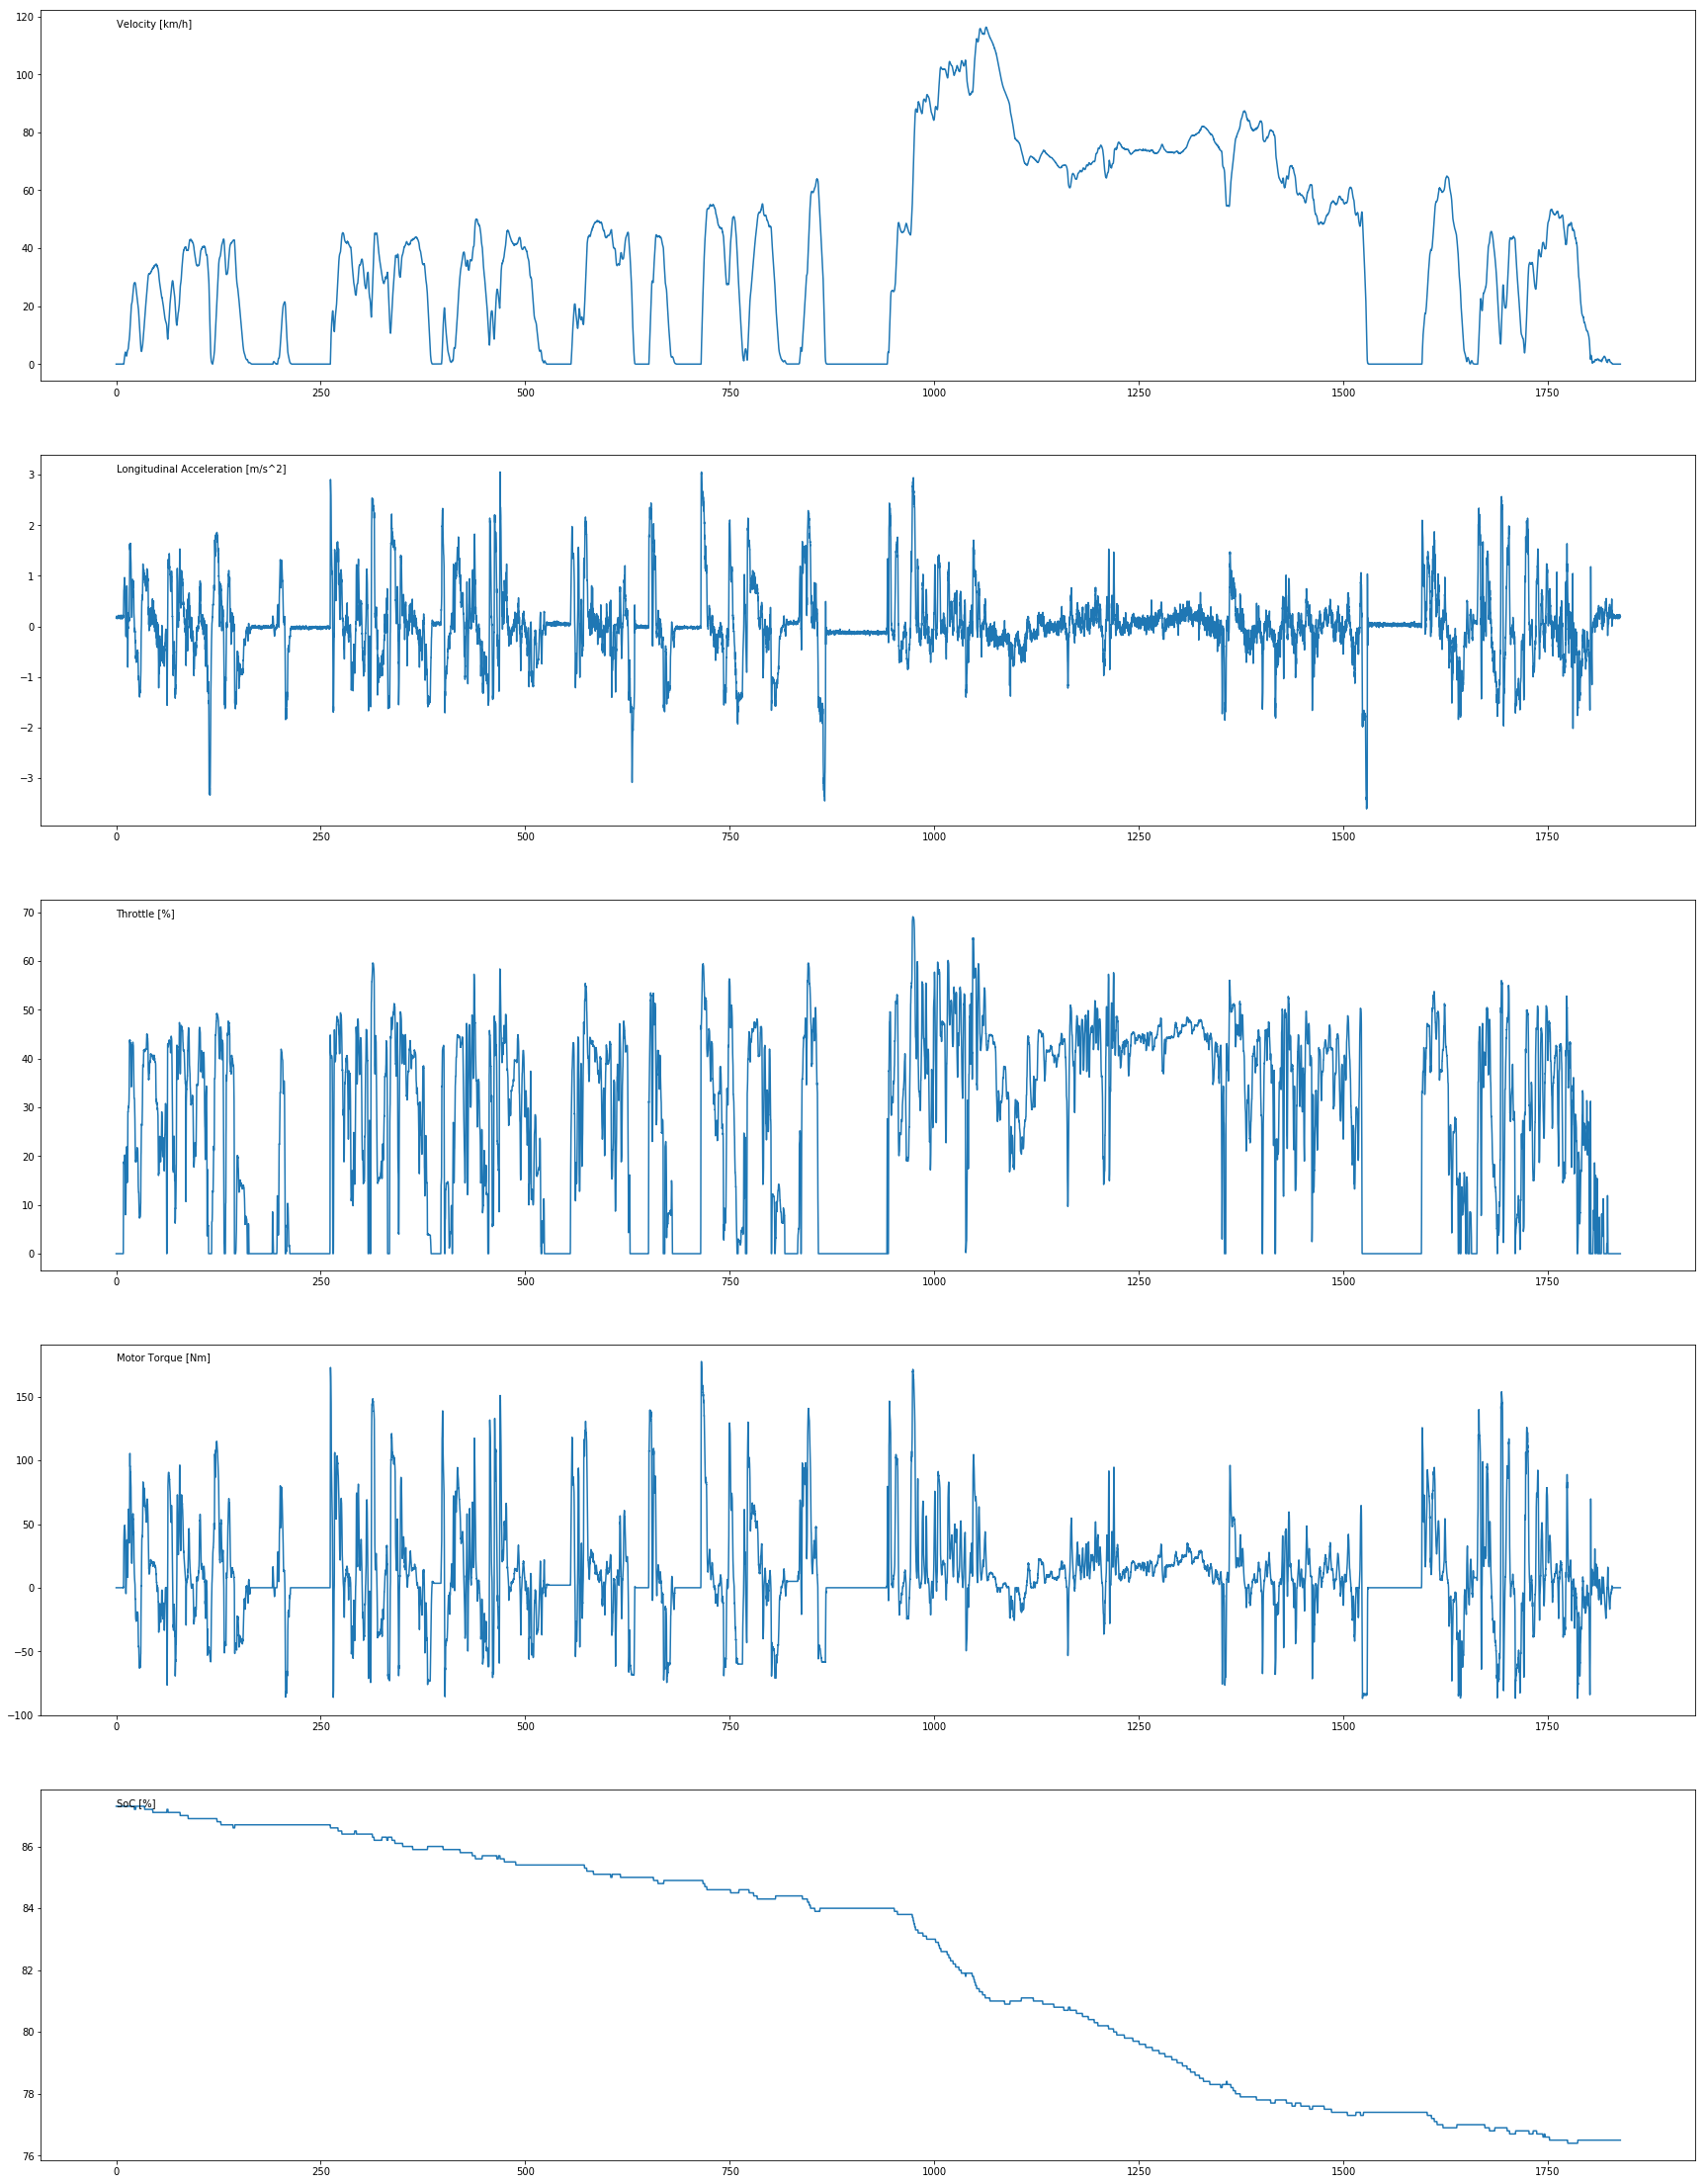

In [10]:
visualize_trip_over_time('TripA22')

Looking at exemplatory trips, we can see that the five chosen measures (Velocity, Acceleration, Throttle, Motor Torque, and State of Charge) are not independent of each other. We see certain plateaus in all diagrams, where four of the measures (Velocity, Acceleration, Throttle, Motor Torque) are zero or close to zero, and the fifth measure (State of Charge) shows no change. Presumably, this happens when the vehicle stops, e.g. at a red traffic light, an intersection, or in a traffic jam. 

# Step 3 | Data Preparation

Next, we will split each trip into micro fragments based on the above chosen measures.
- Micro Fragment 1 'stopped': if the velocity is equal to 0.0 km/h the vehicle has stopped.
- Micro Fragment 2 'cruising': if the velocity is constant within a range of 3 km/h for ten seconds, the vehicle is considered to be cruising.
- Micro Fragment 3 'accelerating': if the velocity increases by more than 10 km/h within three seconds, the vehicle is accelerating.
- Micro Fragment 4 'decelerating': if the velocity decreases by more than 10 km/h within three seconds, the vehicle is decelerating

In [11]:
def split_trip_into_micro_fragments(local_trip_id, plot = True):
    my_trip = trip_df[trip_df['trip_id'] == local_trip_id]
    my_trip_sorted = my_trip.sort_values(by='Time [s]').copy()
    my_trip_sorted['Micro Fragment'] = 'undefined'
    
    # Micro Fragment 1: 'stopped'
    # Definition: if the velocity is equal to 0.0 km/h the vehicle has stopped.
    
    # Micro Fragment 2: 'cruising'
    # Definition: if the velocity is constant within a range of 3 km/h, the vehicle is considered to be cruising.
    
    # Micro Fragment 3: 'accelerating' 
    # Definition: if the velocity increases by more than 10 km/h within three seconds, the vehicle is accelerating.    
    
    # Micro Fragment 4: 'decelerating'
    # Definition: if the velocity decreases by more than 10 km/h within three seconds, the vehicle is decelerating.
    
    cruising_threshold = 3
    accelerating_threshold = 10
    decelerating_threshold = 10

    for i in my_trip_sorted.index:
        
        #Get the velocities of the last 10 seconds
        last_velocities = []
        for r in range(-100,1,10):
            last_velocities.append(my_trip_sorted.iloc[i+r]['Velocity [km/h]'])
            
        # Check if stopping criterion is met
        is_stopped = False
        if np.max(last_velocities[-4:]) == 0:
            is_stopped = True
        if is_stopped: 
            my_trip_sorted.loc[(my_trip_sorted.index <= i) & (my_trip_sorted.index >= i-29), 'Micro Fragment'] = 'stopped'

        # Check if cruising threshold is met
        is_cruising = False
        if abs(np.max(last_velocities) - np.min(last_velocities)) < cruising_threshold:
            if last_velocities[len(last_velocities)-1] > 0:
                is_cruising = True            
        if is_cruising:
            my_trip_sorted.loc[(my_trip_sorted.index <= i) & (my_trip_sorted.index >= i-99), 'Micro Fragment'] = 'cruising'
            
        # Check if accelerating criterion is met
        is_accelerating = False
        if last_velocities[len(last_velocities)-4] < last_velocities[len(last_velocities)-3]:
            if last_velocities[len(last_velocities)-3] < last_velocities[len(last_velocities)-2]:
                if last_velocities[len(last_velocities)-2] < last_velocities[len(last_velocities)-1]:
                    if (last_velocities[len(last_velocities)-1] - last_velocities[len(last_velocities)-4]) > accelerating_threshold:
                        is_accelerating = True
        if is_accelerating:
            my_trip_sorted.loc[(my_trip_sorted.index <= i) & (my_trip_sorted.index >= i-29), 'Micro Fragment'] = 'accelerating'
            
            
        # Check if decelerating criterion is met
        is_decelerating = False
        if last_velocities[len(last_velocities)-4] > last_velocities[len(last_velocities)-3]:
            if last_velocities[len(last_velocities)-3] > last_velocities[len(last_velocities)-2]:
                if last_velocities[len(last_velocities)-2] > last_velocities[len(last_velocities)-1]:
                    if (last_velocities[len(last_velocities)-4] - last_velocities[len(last_velocities)-1]) > decelerating_threshold:
                        is_decelerating = True
        if is_decelerating:
            my_trip_sorted.loc[(my_trip_sorted.index <= i) & (my_trip_sorted.index >= i-29), 'Micro Fragment'] = 'decelerating'
            
    if plot:
        # Setting plot parameters
        plt.rcParams['figure.figsize'] = [70, 10]
        f, (vel_ax, ax) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]})

        # Plotting trip velocity
        vel_ax.plot(my_trip_sorted['Time [s]'], my_trip_sorted['Velocity [km/h]'], color = 'black')

        # Plotting micro fragments of the trip
        ax.plot(my_trip_sorted['Time [s]'], my_trip_sorted['Velocity [km/h]'], color = 'black')
        ax.fill_between(my_trip_sorted['Time [s]'], 0, 1, where= my_trip_sorted['Micro Fragment'] == 'stopped',
                        color='grey', alpha=0.5, transform=ax.get_xaxis_transform())

        ax.fill_between(my_trip_sorted['Time [s]'], 0, 1, where= my_trip_sorted['Micro Fragment'] == 'cruising',
                        color='blue', alpha=0.5, transform=ax.get_xaxis_transform())

        ax.fill_between(my_trip_sorted['Time [s]'], 0, 1, where= my_trip_sorted['Micro Fragment'] == 'accelerating',
                        color='red', alpha=0.5, transform=ax.get_xaxis_transform())

        ax.fill_between(my_trip_sorted['Time [s]'], 0, 1, where= my_trip_sorted['Micro Fragment'] == 'decelerating',
                        color='green', alpha=0.5, transform=ax.get_xaxis_transform())
        
        # Adding auxilliary plot segments
        f.suptitle(('Micro Fragments of ' + local_trip_id + ' based on Velocity in km/h over Time in Seconds'), fontsize=60)
        ax.text(0,-50,"■ Micro Fragment: Stopped", fontsize=40, color='grey')
        ax.text(0.25 * np.max(my_trip_sorted['Time [s]']),-50,"■ Micro Fragment: Cruising", fontsize=40, color='blue')
        ax.text(0.50 * np.max(my_trip_sorted['Time [s]']),-50,"■ Micro Fragment: Accelerating", fontsize=40, color='red')
        ax.text(0.75 * np.max(my_trip_sorted['Time [s]']),-50,"■ Micro Fragment: Decelerating", fontsize=40, color='green')
        
        plt.show()
        
    return my_trip_sorted

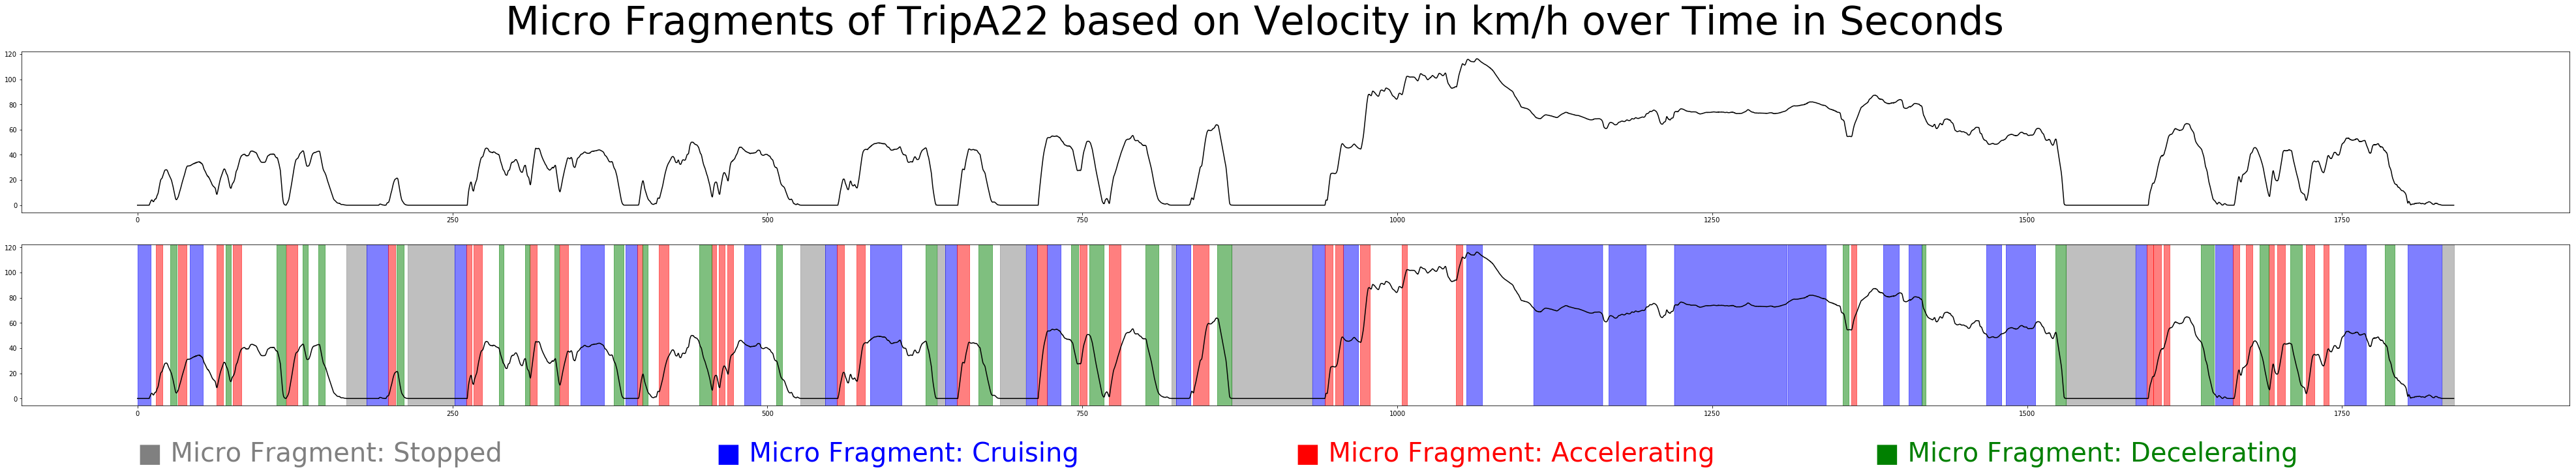

In [12]:
my_tripa22 = split_trip_into_micro_fragments('TripA22')

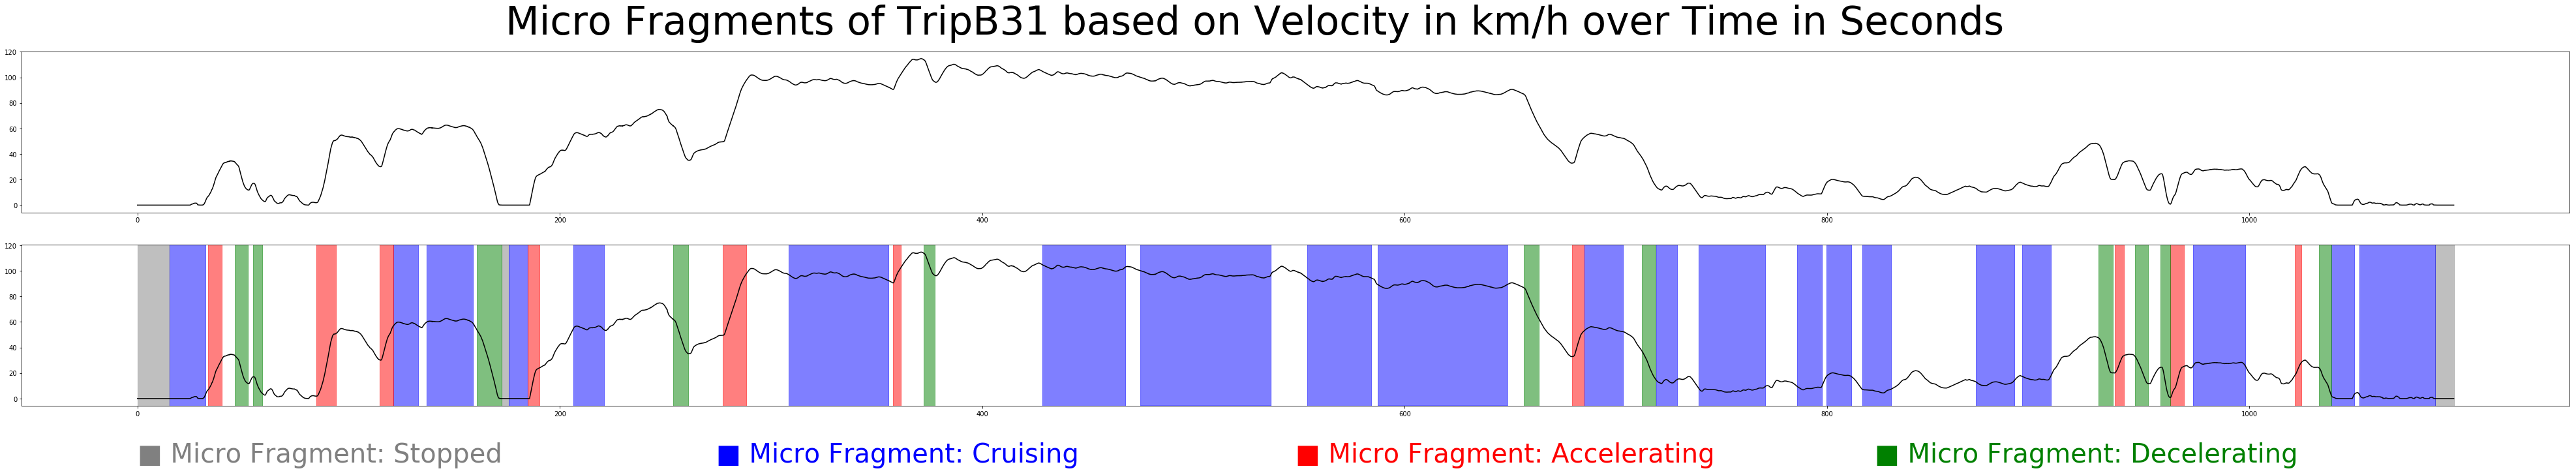

In [13]:
my_tripb31 = split_trip_into_micro_fragments('TripB31')

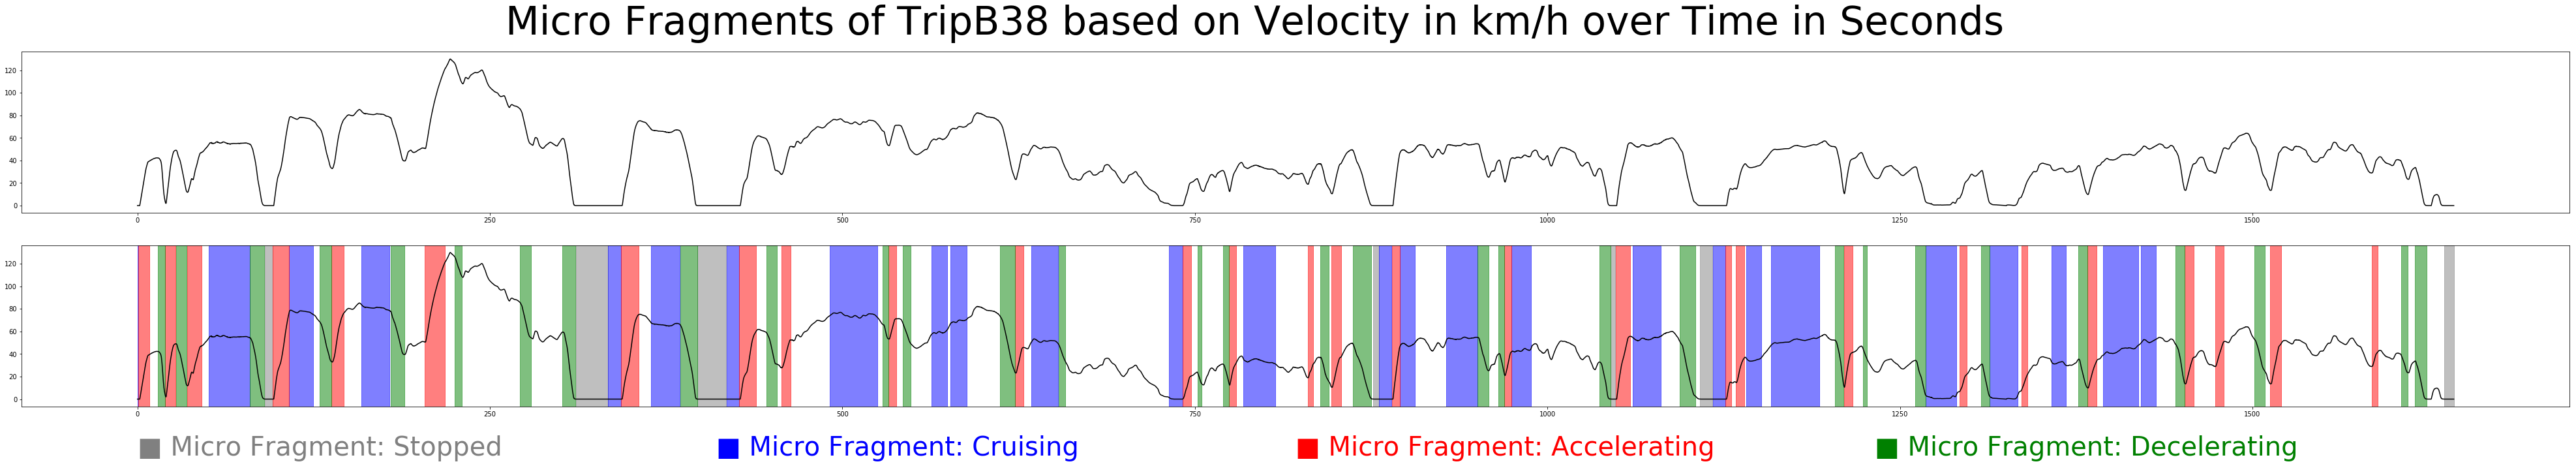

In [14]:
my_tripb38 = split_trip_into_micro_fragments('TripB38')

# Ideas for improving the trip split into micro fragments

In [15]:
# Micro Fragment 1: 'stopped'
## ToDo: how to handle brief stop interruptions, e.g. "roll forward" at a traffic light / intersection with less than X km/h

In [16]:
# Micro Fragment 2: 'cruising'
# To Check: can other factors be considered? Motor Torque, Elevation, Throttle below a certain percentage??

In [17]:
# Micro Fragment 3 and Micro Fragment 4: 'accelerating' and 'decelerating'
# To Check: can other factors be considered? Motor Torque, Throttle above a certain percentage, Acceleration, Braking??

# What Remains to be Said

The data used within this Notebook has been downloaded from Kaggle (https://www.kaggle.com/atechnohazard/battery-and-heating-data-in-real-driving-cycles). It has originally been published by Matthias Steinstraeter (Technical University of Munich, Institute of Automotive Technology), Johannes Buberger (Technical University of Munich, Institute of Automotive Technology), and Dimitar Trifonov (Technical University of Munich, Institute of Automotive Technology) in IEEE Data Portal (https://ieee-dataport.org/open-access/battery-and-heating-data-real-driving-cycles).

Author of this Notebook is: F B

Created in March 2022